In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 13 - Extrasensory perception

## 13.1 Evidence for optional stopping
The negative relation between the number of subjects and effect size suggests that the results are contaminated by optional stopping. Here we inferred on the correlation coefficient (same as in chapter 5):  

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ x_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$

Applied interval-transform to r and added transformed r_interval to model.
Applied log-transform to lambda1 and added transformed lambda1_log to model.
Applied log-transform to lambda2 and added transformed lambda2_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 5.1 sec

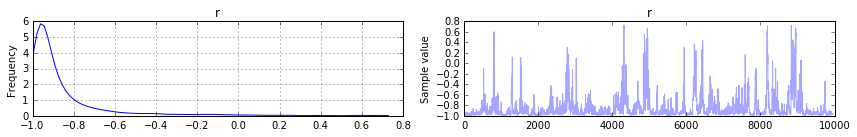

In [2]:
# Sample size N and effect size E in the Bem experiments
N = np.array([100, 150, 97, 99, 100, 150, 200, 100, 50])
E = np.array([.25, .20, .25, .20, .22, .15, .09, .19, .42])

y = np.vstack([N,E]).T
n,n2 = np.shape(y) # number of experiments

with pm.Model() as model1:
    # r∼Uniform(−1,1)
    r =  pm.Uniform("r",lower = -1, upper = 1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal("mu", mu=0, tau = .001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma("lambda1",alpha=.001,beta=.001)
    lambda2 = pm.Gamma("lambda2",alpha=.001,beta=.001)
    sigma1 = pm.Deterministic("sigma1",1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic("sigma2",1/np.sqrt(lambda2))
    
    cov = pm.Deterministic("cov", T.stacklists([[lambda1 ** -1,r*sigma1*sigma2],
                                                [r*sigma1*sigma2,lambda2 ** -1]]))
    
    tau1 = pm.Deterministic("tau1", T.nlinalg.matrix_inverse(cov))
    
    yd = pm.MvNormal("yd", mu = mu, tau = tau1, observed = y)

    trace1=pm.sample(1e4, step=pm.Metropolis(),  model=model1)

pm.traceplot(trace1[50:],varnames=['r']);

the Bayes Factor is  [ 9.4337455]
the approximation Jeffreys Bayes Factor is  16.1957850926
the exact Jeffreys Bayes Factor is  21.53764856080971


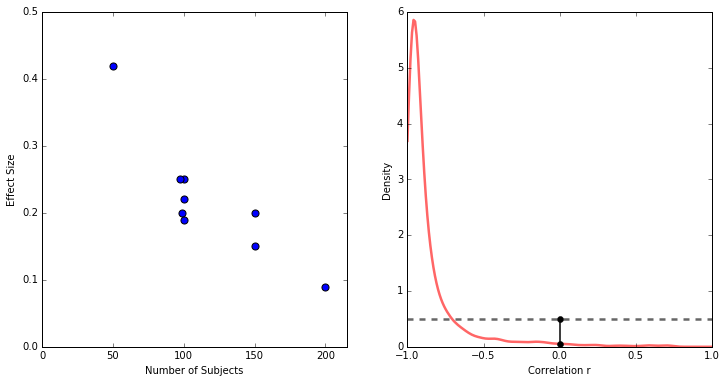

In [3]:
from scipy.stats.kde import gaussian_kde
burnin=50
r = trace1['r'][burnin:]

fig = plt.figure(figsize=(12, 6)) 

gs = gridspec.GridSpec(1,2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.scatter(y[:, 0], y[:, 1],s=50)
plt.axis([0,215,0,.5])
plt.xlabel('Number of Subjects')
plt.ylabel('Effect Size')

my_pdf = gaussian_kde(r)
x=np.linspace(-1, 1, 200)
ax1 = plt.subplot(gs[1])
ax1.plot(x, my_pdf(x),'r',lw=2.5, alpha=0.6,) # distribution function
ax1.plot(x, np.ones(x.size)*.5 ,'k--', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = .5       # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is ',1/BF01)
ax1.plot([0,0], [posterior,prior],'k-', [0,0], [posterior,prior],'ko',lw=1.5, alpha=1)
# ax1.hist(r, bins=100, normed=1,alpha=.3)
plt.xlabel('Correlation r')
plt.ylabel('Density')

# Compare to approximation Jeffreys (1961), pp. 289-292:
import scipy as scipy 
freqr=scipy.corrcoef(y[:, 0], y[:, 1])
BF_Jeffrey=1/(((2*(n-1)-1)/np.pi)**.5 * (1-freqr[0,1]**2)**(.5*((n-1)-3)))
print ('the approximation Jeffreys Bayes Factor is ',BF_Jeffrey)

# Compare to exact solution Jeffreys (numerical integration):
BF_Jeffex = scipy.integrate.quad(lambda rho: ((1-rho**2)**((n-1)/2)) / ((1-rho*freqr[0,1])**((n-1)-.5)), -1, 1)
print('the exact Jeffreys Bayes Factor is ',BF_Jeffex[0]/2)

plt.show()

## 13.2 Evidence for differences in ability
  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (0, 1) $$  
$$ \hat\theta_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$  
$$ \theta_{ij} =  \Phi(\hat\theta_{ij})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

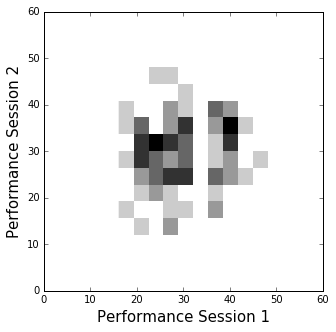

In [4]:
# Data
# Proportion correct on erotic pictures, block 1 and block 2:
prc1er=np.array([0.6000000, 0.5333333, 0.6000000, 0.6000000, 0.4666667, 
              0.6666667, 0.6666667, 0.4000000, 0.6000000, 0.6000000,
              0.4666667, 0.6666667, 0.4666667, 0.6000000, 0.3333333,
              0.4000000, 0.4000000, 0.2666667, 0.3333333, 0.5333333,
              0.6666667, 0.5333333, 0.6000000, 0.4000000, 0.4666667, 
              0.7333333, 0.6666667, 0.6000000, 0.6666667, 0.5333333,
              0.5333333, 0.6666667, 0.4666667, 0.3333333, 0.4000000,
              0.5333333, 0.4000000, 0.4000000, 0.3333333, 0.4666667,
              0.4000000, 0.4666667, 0.4666667, 0.5333333, 0.3333333,
              0.7333333, 0.2666667, 0.6000000, 0.5333333, 0.4666667,
              0.4000000, 0.5333333, 0.6666667, 0.4666667, 0.5333333,
              0.5333333, 0.4666667, 0.4000000, 0.4666667, 0.6666667,
              0.4666667, 0.3333333, 0.3333333, 0.3333333, 0.4000000,
              0.4000000, 0.6000000, 0.4666667, 0.3333333, 0.3333333,
              0.6666667, 0.5333333, 0.3333333, 0.6000000, 0.4666667,
              0.4666667, 0.4000000, 0.3333333, 0.4666667, 0.5333333,
              0.8000000, 0.4000000, 0.5333333, 0.5333333, 0.6666667,
              0.6666667, 0.6666667, 0.6000000, 0.6000000, 0.5333333,
              0.3333333, 0.4666667, 0.6666667, 0.5333333, 0.3333333,
              0.3333333, 0.2666667, 0.2666667, 0.4666667, 0.6666667])

prc2er=np.array([0.3333333, 0.6000000, 0.5333333, 0.2666667, 0.6666667,
              0.5333333, 0.6666667, 0.4666667, 0.4666667, 0.6666667,
              0.4000000, 0.6666667, 0.2666667, 0.4000000, 0.4666667,
              0.3333333, 0.5333333, 0.6000000, 0.3333333, 0.4000000,
              0.4666667, 0.4666667, 0.6000000, 0.5333333, 0.5333333,
              0.6000000, 0.5333333, 0.6666667, 0.6000000, 0.2666667,
              0.4666667, 0.4000000, 0.6000000, 0.5333333, 0.4000000,
              0.4666667, 0.5333333, 0.3333333, 0.4000000, 0.4666667,
              0.8000000, 0.6000000, 0.2000000, 0.6000000, 0.4000000,
              0.4000000, 0.2666667, 0.2666667, 0.6000000, 0.4000000,
              0.4000000, 0.4000000, 0.4000000, 0.4000000, 0.6666667,
              0.7333333, 0.5333333, 0.5333333, 0.3333333, 0.6000000,
              0.5333333, 0.5333333, 0.4666667, 0.5333333, 0.4666667,
              0.5333333, 0.4000000, 0.4000000, 0.4666667, 0.6000000,
              0.6000000, 0.6000000, 0.4666667, 0.6000000, 0.6666667,
              0.5333333, 0.4666667, 0.6000000, 0.2000000, 0.5333333,
              0.4666667, 0.4000000, 0.5333333, 0.5333333, 0.5333333,
              0.5333333, 0.6000000, 0.6666667, 0.4000000, 0.4000000,
              0.5333333, 0.8000000, 0.6000000, 0.4000000, 0.2000000,
              0.6000000, 0.6666667, 0.4666667, 0.4666667, 0.4666667])             
Nt = 60
xobs = np.vstack([prc1er,prc2er]).T*Nt
n,n2 = np.shape(xobs) # number of participants

plt.figure(figsize=[5,5])
plt.hist2d(xobs[:,0],xobs[:,1],cmap = 'binary')
plt.xlabel('Performance Session 1',fontsize=15)
plt.ylabel('Performance Session 2',fontsize=15)
plt.axis([0,60,0,60])
plt.show()

Applied interval-transform to r and added transformed r_interval to model.
Applied log-transform to lambda1 and added transformed lambda1_log to model.
Applied log-transform to lambda2 and added transformed lambda2_log to model.
Assigned NUTS to r_interval
Assigned NUTS to mu
Assigned NUTS to lambda1_log
Assigned NUTS to lambda2_log
Assigned NUTS to thetai
 [-----------------100%-----------------] 3000 of 3000 complete in 139.1 sec

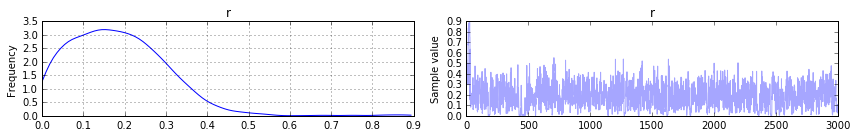

In [5]:
with pm.Model() as model2:
    # r∼Uniform(−1,1)
    r =  pm.Uniform("r",lower = 0, upper = 1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal("mu", mu=0, tau = .001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma("lambda1",alpha=.001,beta=.001,testval=100)
    lambda2 = pm.Gamma("lambda2",alpha=.001,beta=.001,testval=100)
    sigma1 = pm.Deterministic("sigma1",1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic("sigma2",1/np.sqrt(lambda2))
    
    cov = pm.Deterministic("cov", T.stacklists([[lambda1 ** -1,r*sigma1*sigma2],
                                                [r*sigma1*sigma2,lambda2 ** -1]]))
    
    tau1 = pm.Deterministic("tau1", T.nlinalg.matrix_inverse(cov))
    
#     kij = pm.MvNormal("kij",mu = mu, tau=tau1,observed=xobs/Nt)
#     trace2=pm.sample(3e3, model=model2)

    def Phi(x):
        # probit transform 
        return (1.0 + T.erf(x / np.sqrt(2.0))) / 2.0
    thetai = pm.MvNormal("thetai", mu = mu, tau = tau1, shape=(n,n2))
    theta = Phi(thetai)
    kij = pm.Binomial("kij", p=theta, n=Nt, observed=xobs)
    
    # start = pm.find_MAP()
    # step = pm.NUTS(scaling=start)
    # trace2=pm.sample(3e5, start=start, step=pm.Metropolis(), model=model2)
    
    trace2=pm.sample(3e3, model=model2)

pm.traceplot(trace2[:],varnames=['r']);

the Bayes Factor is  [ 0.76282474]
the exact Jeffreys Bayes Factor is  0.4561173937820748


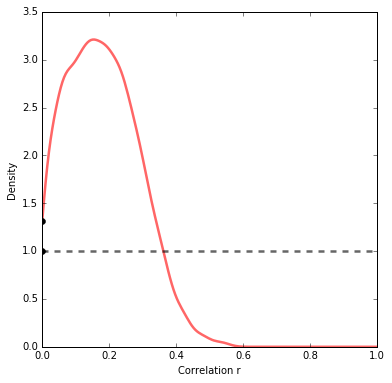

In [6]:
from scipy.stats.kde import gaussian_kde
r = trace2['r'][50:]

fig = plt.figure(figsize=(6, 6)) 

my_pdf = gaussian_kde(r)
x1=np.linspace(0, 1, 200)

plt.plot(x1, my_pdf(x1),'r',lw=2.5, alpha=0.6,) # distribution function
plt.plot(x1, np.ones(x1.size) ,'k--', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)        # this gives the pdf at point delta = 0
prior     = 1       # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is ',1/BF01)
plt.plot([0,0], [posterior,prior],'k-', [0,0], [posterior,prior],'ko',lw=1.5, alpha=1)
# ax1.hist(r, bins=100, normed=1,alpha=.3)
plt.xlim([0,1])
plt.xlabel('Correlation r')
plt.ylabel('Density')

# Compare to exact solution Jeffreys (numerical integration):
freqr=scipy.corrcoef(xobs[:, 0]/Nt, xobs[:, 1]/Nt)
BF_Jeffex = scipy.integrate.quad(lambda rho: ((1-rho**2)**((n-1)/2)) / ((1-rho*freqr[0,1])**((n-1)-.5)), 0, 1)
print('the exact Jeffreys Bayes Factor is ',BF_Jeffex[0])

plt.show()

## 13.3 Evidence for the impact of extraversion
  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ \hat\theta_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$  
$$ \theta_{i1} =  \Phi(\hat\theta_{i1})$$
$$ \theta_{i2} =  100\Phi(\hat\theta_{i2})$$
$$ k_{i} \sim \text{Binomial}(\theta_{i1},n)$$
$$ x_{i} \sim \text{Gaussian}(\theta_{i2},\lambda^x)$$

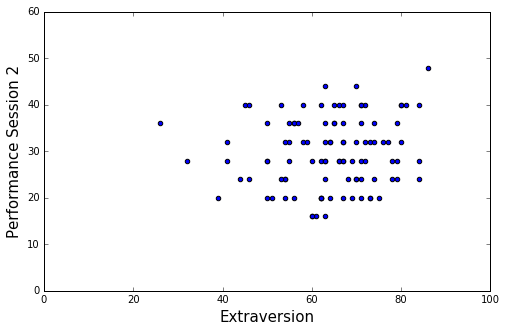

In [11]:
k2 = np.array([36, 32, 36, 36, 28, 40, 40, 24, 36, 36, 28, 40, 28, 
       36, 20, 24, 24, 16, 20, 32, 40, 32, 36, 24, 28, 44,
       40, 36, 40, 32, 32, 40, 28, 20, 24, 32, 24, 24, 20, 
       28, 24, 28, 28, 32, 20, 44, 16, 36, 32, 28, 24, 32,
       40, 28, 32, 32, 28, 24, 28, 40, 28, 20, 20, 20, 24,
       24, 36, 28, 20, 20, 40, 32, 20, 36, 28, 28, 24, 20,
       28, 32, 48, 24, 32, 32, 40, 40, 40, 36, 36, 32, 20,
       28, 40, 32, 20, 20, 16, 16, 28, 40])
       
x2 = np.array([50, 80, 79, 56, 50, 80, 53, 84, 74, 67, 50, 45, 62, 
       65, 71, 71, 68, 63, 67, 58, 72, 73, 63, 54, 63, 70, 
       81, 71, 66, 74, 70, 84, 66, 73, 78, 64, 54, 74, 62, 
       71, 70, 79, 66, 64, 62, 63, 60, 56, 72, 72, 79, 67, 
       46, 67, 77, 55, 63, 44, 84, 65, 41, 62, 64, 51, 46,
       53, 26, 67, 73, 39, 62, 59, 75, 65, 60, 69, 63, 69, 
       55, 63, 86, 70, 67, 54, 80, 71, 71, 55, 57, 41, 56, 
       78, 58, 76, 54, 50, 61, 60, 32, 67])
       
nsubjs = len(k2)
ntrials = 60
sigmax = 3

plt.figure(figsize=[8,5])
plt.scatter(x2,k2)
plt.xlabel('Extraversion',fontsize=15)
plt.ylabel('Performance Session 2',fontsize=15)
plt.axis([0,100,0,60])
plt.show()

Applied interval-transform to r and added transformed r_interval to model.
Applied log-transform to lambda1 and added transformed lambda1_log to model.
Applied log-transform to lambda2 and added transformed lambda2_log to model.
Assigned NUTS to r_interval
Assigned NUTS to mu
Assigned NUTS to lambda1_log
Assigned NUTS to lambda2_log
Assigned NUTS to thetai
 [-----------------100%-----------------] 3000 of 3000 complete in 135.6 sec

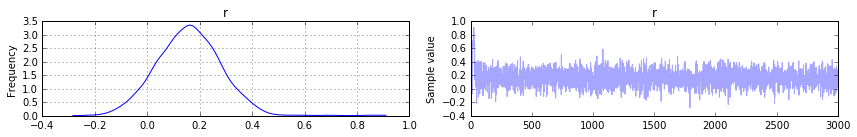

In [13]:
with pm.Model() as model3:
    # r∼Uniform(−1,1)
    r =  pm.Uniform("r",lower = -1, upper = 1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal("mu", mu=0, tau = .001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma("lambda1",alpha=.001,beta=.001,testval=100)
    lambda2 = pm.Gamma("lambda2",alpha=.001,beta=.001,testval=100)
    sigma1 = pm.Deterministic("sigma1",1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic("sigma2",1/np.sqrt(lambda2))
    
    cov = pm.Deterministic("cov", T.stacklists([[lambda1 ** -1,r*sigma1*sigma2],
                                                [r*sigma1*sigma2,lambda2 ** -1]]))
    
    tau1 = pm.Deterministic("tau1", T.nlinalg.matrix_inverse(cov))
    
    def Phi(x):
        # probit transform 
        return (1.0 + T.erf(x / np.sqrt(2.0))) / 2.0
    thetai = pm.MvNormal("thetai", mu = mu, tau = tau1, shape=(n,n2))
    theta1 = Phi(thetai[:,0])
    theta2 = 100 * Phi(thetai[:,1])
    
    ki = pm.Binomial("ki", p=theta1, n=Nt, observed=k2)
    xi = pm.Normal("xi",mu=theta2,sd=sigmax,observed=x2)
    
    trace3=pm.sample(3e3, model=model3)

pm.traceplot(trace3[:],varnames=['r']);

the Bayes Factor is  [ 0.36092444]


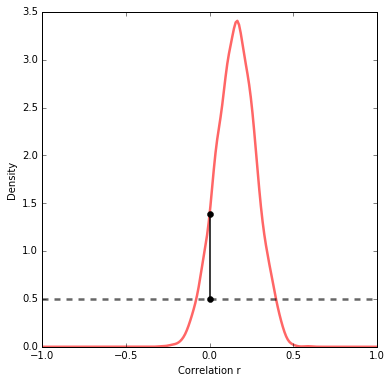

In [16]:
r = trace3['r'][50:]

fig = plt.figure(figsize=(6, 6)) 

my_pdf = gaussian_kde(r)
x1=np.linspace(-1, 1, 200)

plt.plot(x1, my_pdf(x1),'r',lw=2.5, alpha=0.6,) # distribution function
plt.plot(x1, np.ones(x1.size)*.5,'k--', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)        # this gives the pdf at point delta = 0
prior     = .5       # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is ',1/BF01)
plt.plot([0,0], [posterior,prior],'k-', [0,0], [posterior,prior],'ko',lw=1.5, alpha=1)
# ax1.hist(r, bins=100, normed=1,alpha=.3)
plt.xlim([-1,1])
plt.xlabel('Correlation r')
plt.ylabel('Density')

plt.show()